# 식품 배송 데이터 분석

## 데이터 생성

* 앞서 다운받았던 케글의 instacart 데이터를 이용한다.

## Instacart Dataset

* aisles, department는 상품의 카테고리를 의미하고, order_products_prior는 각 주문 번호의 상세 구매 내역, orders는 주문 대표 정보, product는 상품 정보를 포함한다.

## 지표 추출

### 1. 전체 주문 건수

* 주문 건수를 계산하기 전에 데이터의 중복 여부를 확인하는 것이 필요하다.
* 데이터의 정합성을 보장하는 것은 매우 중요한 일이므로 쿼리를 작성하기 전, 항상 데이터의 구조를 정확히 파악하고 수치를 구할 필요가 있다.
* 주문 건수와 구매자 수는 다음과 같은 방법으로 구할 수 있다.

In [ ]:
# 주문 건수
SELECT COUNT(DISTINCT order_id) F
FROM orders;

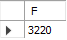

### 2. 구매자 수

In [ ]:
# 구매자 수
SELECT COUNT(DISTINCT user_id) BU
FROM orders;

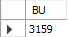

* 주문 건수와 구매자 수의 경우 Orders 테이블에서 중복으로 존재 가능하므로 distinct를 이용해 중복을 제외하고 카운트한다.

### 3. 상품별 주문 건수

* 상품명으로 데이터를 그룹핑하고 order_id를 집계하면 된다.
* 주문번호(order_id)는 order_products__prior라는 테이블에 존재하고, 상품명(product_name)은 products 테이블에 존재한다.
* 그러므로 테이블을 조인하는 쿼리를 추가해야 할것이다.

In [ ]:
# 테이블을 조인
SELECT *
FROM order_products__prior A
LEFT JOIN
products B
ON A.product_id = B.product_id;

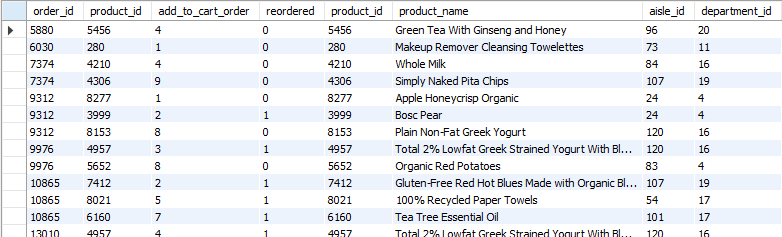

* 결합한 결과에서 product_name으로 데이터를 그룹핑하고, order_id를 카운트하면 된다.
* 주문 번호는 동일한 값이 중복으로 존재하므로 제거하고 집계해야 한다.

In [ ]:
# product_name으로 데이터 그룹핑
SELECT B.product_name, COUNT(DISTINCT A.order_id) F
FROM order_products__prior A
LEFT JOIN
products B
ON A.product_id = B.product_id
GROUP BY 1;

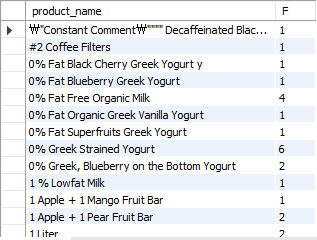

### 4. 장바구니에 가장 먼저 넣는 상품 10개

* 우리는 쇼핑몰에서 물건을 구입할 때, 장바구니 담기라는 기능을 자주 사용한다.
* 가장 필요한 상품을 먼저 검색하고 장바구니에 담는 경향이 있다.
* order_products__prior라는 테이블을 보면 add_to_cart_order라는 컬럼이 존재한다. -> 상품이 몇 번째로 장바구니에 담겼는지 의미
* 카트에 가장 먼저 담기는 상품을 조회하기 위해서 상품별로 가장 먼저 담긴 카트에 담긴 경우를 카운트한다.
* 예를 들어 mineral water라는 상품이 A라는 주문 건에서 두 번째로 담기고, B라는 주문 건에서 첫 번째로 담기는 경우에 mineral water가 첫 번째로 카트에 담긴 건수는 1이 된다.
* order_products__prior의 product_id별로 가장 먼저 담긴 경우에는 1을 출력하는 쿼리를 다음과 같이 작성할 수 있다.

In [ ]:
# order_products__prior의 product_id별로 가장 먼저 담긴 경우에는 1을 출력
SELECT product_id,
CASE WHEN add_to_cart_order = 1 THEN 1 ELSE 0 END F_1st
FROM order_products__prior;

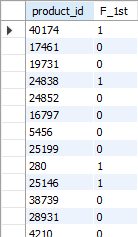

* 다음으로 상품 번호로 데이터를 그룹핑하고 위의 F_1st컬럼을 합하면, 상품별로 장바구니에 가장 먼저 담긴 건수를 계산할 수 있다.

In [ ]:
# 상품별로 장바구니에 가장 먼저 담긴 건수를 계산
SELECT product_id,
SUM(CASE WHEN add_to_cart_order = 1 THEN 1 ELSE 0 END) F_1st
FROM order_products__prior
GROUP BY 1;

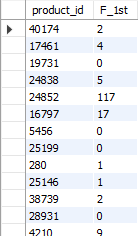

* F_1st로 데이터에 순서를 매긴다.

In [ ]:
# F_1st로 데이터에 순서 정립
SELECT *,
ROW_NUMBER() OVER(ORDER BY F_1st DESC) RNK
FROM
(SELECT product_id,
SUM(CASE WHEN add_to_cart_order = 1 THEN 1 ELSE 0 END) F_1st
FROM order_products__prior
GROUP BY 1) A;

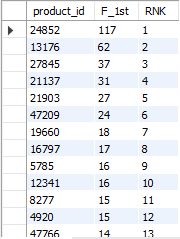

* 1-10위의 상품 번호만 궁금하므로 WHERE절에 조건을 추가해 RNK가 1-10사이인 데이터만 출력한다.
* 이때 RNK는 SELECT문에서 새롭게 생성한 컬럼이므로 WHERE절에서 바로 사용할 수가 없다.
* 위의 쿼리를 서브쿼리로 사용해 조건을 생성해야 한다.

In [ ]:
# WHERE절에 조건을 추가해 RNK가 1-10사이인 데이터만 출력
SELECT *
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY F_1st DESC) RNK
FROM
(SELECT product_id,
SUM(CASE WHEN add_to_cart_order = 1 THEN 1 ELSE 0 END) F_1st
FROM order_products__prior
GROUP BY 1) A) BASE
WHERE RNK BETWEEN 1 AND 10;

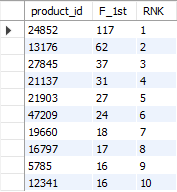

In [ ]:
# ORDER BY를 이용하여 상위10개의 데이터 호출
SELECT product_id,
SUM(CASE WHEN add_to_cart_order = 1 THEN 1 ELSE 0 END) F_1st
FROM order_products__prior
GROUP BY 1
ORDER BY 2 DESC LIMIT 10;

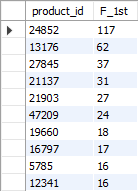

### 5. 시간별 주문 건수

* orders의 order_hour_of_day로 그룹핑한 뒤, order_id를 카운트한다.
* 마찬가지로 order_id 중복을 방지하기 위해 distinct를 추가한다.

In [ ]:
# 시간별 주문 건수
SELECT order_hour_of_day,
COUNT(DISTINCT order_id) F
FROM orders
GROUP BY 1
ORDER BY 1;

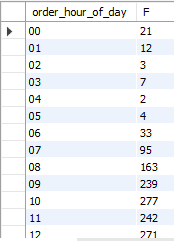

### 6. 첫 구매 후 다음 구매까지 걸린 평균 일수

* days_since_prior_order는 이전 주문이 이루어진 지 며칠 뒤에 구매가 이루어졌는지를 나타내는 값이다.
* 주문 번호의 order_number가 2인(유저의 2번째 주문 건) days_since_prior_order는 첫 구매 후 다음 구매까지 걸린 기간이 된다.
* 이 기간을 평균하면 첫 구매 후 다음 구매까지 걸린 평균 일수를 계산할 수 있다.

In [ ]:
# 첫 구매 후 다음 구매까지 걸린 평균 일수
SELECT AVG(days_since_prior_order) AVG_Recency
FROM orders
WHERE order_number = 2;

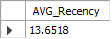

### 7. 주문 건당 평균 구매 상품(UPT, Unit Per Transaction)

* product_id를 카운트해 상품 개수를 계산하고, 이를 주문 건수로 나누어 주문 1건에 평균적으로 몇 개의 상품을 구매하는지 파악할 수 있다.

In [ ]:
# 주문 건당 평균 구매 상품
SELECT COUNT(product_id) / COUNT(DISTINCT order_id) UPT
FROM order_products__prior;

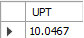

### 8. 인당 평균 주문 건수

* 전체 주문 건수를 구매자 수로 나누어 인당 평균 주문 건수를 계산할 수 있다.

In [ ]:
# 인당 평균 주문 건수
SELECT COUNT(order_id) / COUNT(DISTINCT user_id) UPT
FROM orders;

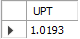

### 9. 재구매율이 가장 높은 상품 10개

* 상품별로 재구매울을 계산한 뒤, 재구매율을 기준으로 링크를 계산한다.
* 이후, 원하는 랭크 값(1-10)으로 조건을 생성한다.

#### 상품별 재구매율 계산

* 상품 번호로 데이터를 그룹핑하고, 재구매 수(SUM(CASE WHEN reordered = 1 THEN 1 ELSE 0 END))를 전체 구매 수(COUNT(*))로 나누어 재구매율 계산한다.

In [ ]:
# 상품별 재구매율 계산
SELECT product_id,
SUM(CASE WHEN reordered = 1 THEN 1 ELSE 0 END) / COUNT(*) Ret_Ratio
FROM order_products__prior
GROUP BY 1;

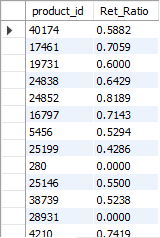

#### 재구매율로 랭크(순위) 열 생성하기

* 재구매율로 순위를 매기려면 앞의 결과를 서브쿼리로 생성하고, SELECT문에서 ROW_NUMBER/RANK/DENSE_RANK 중 하나를 선택해 순위 열을 생성한다.

In [ ]:
# 재구매율로 랭크(순위) 열 생성
SELECT *,
ROW_NUMBER() OVER(ORDER BY Ret_Ratio DESC) RNK
FROM
(SELECT product_id,
SUM(CASE WHEN reordered = 1 THEN 1 ELSE 0 END) / COUNT(*) Ret_Ratio
FROM order_products__prior
GROUP BY 1) A;

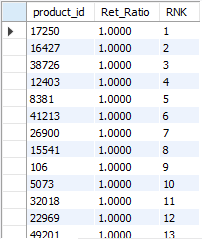

#### Top 10(재구매율) 상품 추출

* 생성한 순위 열 값이 1-10사이인 데이터를 조회하면, 처음 구하고자 했던 Top10(재구매율) 상품 번호를 추출할 수 있다.

In [ ]:
# Top 10(재구매율) 상품 추출
SELECT *
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY Ret_Ratio DESC) RNK
FROM
(SELECT product_id,
SUM(CASE WHEN reordered = 1 THEN 1 ELSE 0 END) / COUNT(*) Ret_Ratio
FROM order_products__prior
GROUP BY 1) A) A
WHERE RNK BETWEEN 1 AND 10;

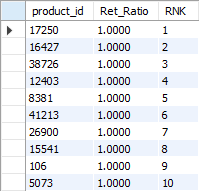

### 10. Department별 재구매율이 가장 높은 상품 10개

* Department별로 재구매율이 높은 상품을 추출하려면, Department별, 상품별 재구매율을 계산한다.
* 다음 Department로 Partition을 생성한 뒤 랭크를 계산하면 된다.
* 이후 원하는 조건을 생성하면 Department별 재구매율 상위 10개의 데이터를 추출할 수 있다.
* 앞의 예제에서 추가된 내용은 order_products__prior에 products 테이블을 조인해 Department를 가져와야 한다는 점과 Department로 Partition을 생성해 순위를 매겨야 한다는 점이다.
* 다음과 같은 방법으로 Department별 재구매율 상위 10개 상품을 출력할 수 있다.

In [ ]:
# Department별 재구매율이 가장 높은 상품 10개
SELECT *
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY Ret_Ratio DESC) RNK
FROM
(SELECT C.department, A.product_id,
SUM(CASE WHEN reordered = 1 THEN 1 ELSE 0 END) / COUNT(*) Ret_Ratio
FROM order_products__prior A
LEFT JOIN
products B
ON A.product_id = B.product_id
LEFT JOIN
departments C
ON B.department_id = C.department_id
GROUP BY 1, 2) A) A
WHERE RNK BETWEEN 1 AND 10;

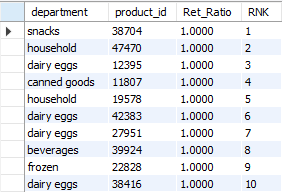

### 1. 10분위 분석

* 고객별로 주문 건수를 계산한 뒤, 주문 건수를 기준으로 각 고객이 어떤 그룹에 속하는지 구한다.
* 다음으로 각 분위 위수별 주문 건수의 합을 구하면, 전체 주문 건이 어떤 그룹에 얼마나 집중되어 있는지 계산할 수 있다.

### 10분위 분석
* 전체를 10분위로 나누어 각 분위 수에 해당하는 집단의 성질을 나타내는 방법
* 10분위 분석을 진행하려면 각 구매자의 분위 수를 구해야 한다.

* 고객들의 주문 건수를 기준으로 분위 수를 나눈다.
* 다음과 같은 방법으로 주문 건수에 따른 Rank를 생성한다.

In [ ]:
# 주문 건수에 따른 Rank를 생성
SELECT *,
ROW_NUMBER() OVER(ORDER BY F DESC) RNK
FROM
(SELECT user_id, COUNT(DISTINCT order_id) F
FROM orders
GROUP BY 1) A;

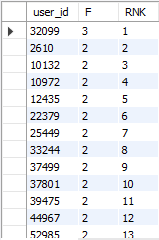

* 고객별 주문 건수에 따라 순위가 매겨진다. 고객별로 분위 수를 매기려면 전체 고객이 몇 명인지 알아야 한다.
* 다음과 같은 방법으로 전체 고객 수를 계산한다.

In [ ]:
# 전체 고객 수 계산
SELECT COUNT(DISTINCT user_id)
FROM
(SELECT user_id,
COUNT(DISTINCT order_id) F
FROM orders
GROUP BY
1) A;

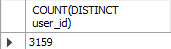

* 각 등수에 따른 분위수는 case when구문을 이용해 다음과 같은 방법으로 설정할 수 있다.

In [ ]:
# 각 등수에 따른 분위수
SELECT *,
CASE WHEN RNK BETWEEN 1 AND 316 THEN 'Quantile 1'
WHEN RNK BETWEEN 317 AND 632 THEN 'Quantile 2'
WHEN RNK BETWEEN 633 AND 948 THEN 'Quantile 3'
WHEN RNK BETWEEN 949 AND 1264 THEN 'Quantile 4'
WHEN RNK BETWEEN 1265 AND 1580 THEN 'Quantile 5'
WHEN RNK BETWEEN 1581 AND 1895 THEN 'Quantile 6'
WHEN RNK BETWEEN 1896 AND 2211 THEN 'Quantile 7'
WHEN RNK BETWEEN 2212 AND 2527 THEN 'Quantile 8'
WHEN RNK BETWEEN 2528 AND 2843 THEN 'Quantile 9'
WHEN RNK BETWEEN 2844 AND 3159 THEN 'Quantile 10' END quantile
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY F DESC) RNK
FROM
(SELECT user_id,
COUNT(DISTINCT order_id) F
FROM orders
GROUP BY 1) A) A;

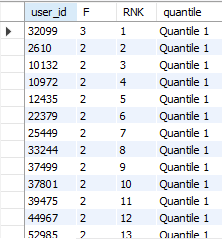

* CASE WHEN 구문에서는 각 분위 수별로 등수를 지정했는데, 모든 등수를 기재할 필요 없이 다음과 같은 방법으로도 처리 가능하다.

In [ ]:
# 각 등수에 따른 분위수2
SELECT *,
CASE WHEN RNK <= 316 THEN 'Quantile 1'
WHEN RNK <= 632 THEN 'Quantile 2'
WHEN RNK <= 948 THEN 'Quantile 3'
WHEN RNK <= 1264 THEN 'Quantile 4'
WHEN RNK <= 1580 THEN 'Quantile 5'
WHEN RNK <= 1895 THEN 'Quantile 6'
WHEN RNK <= 2211 THEN 'Quantile 7'
WHEN RNK <= 2527 THEN 'Quantile 8'
WHEN RNK <= 2843 THEN 'Quantile 9'
WHEN RNK <= 3159 THEN 'Quantile 10' END quantile
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY F DESC) RNK
FROM
(SELECT user_id,
COUNT(DISTINCT order_id) F
FROM orders
GROUP BY 1) A) A;

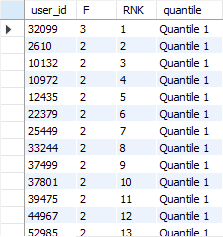

* 각 분위 수별 특성을 파악해보고자 한다. 각 분위 수별로 평균 Recency를 파악한다.
* 먼저 위의 조회 결과를 하나의 테이블로 생성해 user_id별 분위 수 정보를 생성한다.

In [ ]:
# 위의 조회 결과를 하나의 테이블로 생성해 user_id별 분위 수 정보 생성
CREATE TEMPORARY TABLE user_quantile AS
SELECT *,
CASE WHEN RNK <= 316 THEN 'Quantile 1'
WHEN RNK <= 632 THEN 'Quantile 2'
WHEN RNK <= 948 THEN 'Quantile 3'
WHEN RNK <= 1264 THEN 'Quantile 4'
WHEN RNK <= 1580 THEN 'Quantile 5'
WHEN RNK <= 1895 THEN 'Quantile 6'
WHEN RNK <= 2211 THEN 'Quantile 7'
WHEN RNK <= 2527 THEN 'Quantile 8'
WHEN RNK <= 2843 THEN 'Quantile 9'
WHEN RNK <= 3159 THEN 'Quantile 10' END quantile
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY F DESC) RNK
FROM
(SELECT user_id,
COUNT(DISTINCT order_id) F
FROM orders
GROUP BY 1) A) A;


* 이제 다음과 같은 방법으로 각 분위 수별 전체 주문 건수의 합을 구할 수 있다.

In [ ]:
# 각 분위 수별 전체 주문 건수의 합
SELECT quantile,
SUM(F) F
FROM user_quantile
GROUP BY 1;

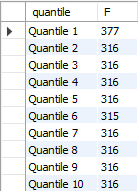